# <center>Рекомендательная система на основе эмбеддингов для датасета MovieLens</center>

## Первичный анализ и предобработка данных

### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import re
import tqdm

### Загрузка данных

In [3]:
movies_df = pd.read_csv("ml-latest\movies.csv", index_col='movieId')
movies_df.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [4]:
#tags_df = pd.read_csv('/kaggle/input/grouplens-2018/ml-latest/tags.csv')
#tags_df.head()

In [4]:
ratings_df = pd.read_csv(r"ml-latest\ratings.csv").iloc[:1_000_000]
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [5]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1000000 non-null  int64  
 1   movieId    1000000 non-null  int64  
 2   rating     1000000 non-null  float64
 3   timestamp  1000000 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 30.5 MB


### Обработка датасета с фильмами

In [6]:
genres_list = ['Action', 'Adventure','Animation',"Children", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 
               'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', '(no genres listed)', 'IMAX']

In [7]:
movies_df['year'] = 0
movies_df['year'] = movies_df['year'].astype(int)

for genre in genres_list:
    movies_df[genre] = 0
    movies_df[genre] = movies_df[genre].astype(int)

Применение one-hot one hot encoding для кодирования жанров

In [8]:
for index, row in tqdm.tqdm(movies_df.iterrows()):
    movieId = index
    title = row.title
    matcher = re.compile('\s*\(\d{4}\)')
    if matcher.search(title) is not None:
        parenthesis_year = matcher.search(title).group(0)
        matcher = re.compile('\s*\d{4}')
        year = matcher.search(parenthesis_year).group(0)
        movies_df.loc[index, 'year'] = int(year)
        movies_df.loc[index, 'title'] = re.sub(r'\s*\(\d{4}\)', "", title)
    
    try:
        genres = row.genres.split('|') 
    except Exception:
        genres = list(row.genres)
    
    for genre in genres:
        movies_df.loc[index, genre] = 1
    

58098it [00:24, 2405.74it/s]


In [9]:
movies_df = movies_df.drop('genres', axis=1)
movies_df.head()

,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,(no genres listed),IMAX
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story,1995,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jumanji,1995,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men,1995,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,Waiting to Exhale,1995,0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58098 entries, 1 to 193886
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               58098 non-null  object
 1   year                58098 non-null  int32 
 2   Action              58098 non-null  int32 
 3   Adventure           58098 non-null  int32 
 4   Animation           58098 non-null  int32 
 5   Children            58098 non-null  int32 
 6   Comedy              58098 non-null  int32 
 7   Crime               58098 non-null  int32 
 8   Documentary         58098 non-null  int32 
 9   Drama               58098 non-null  int32 
 10  Fantasy             58098 non-null  int32 
 11  Film-Noir           58098 non-null  int32 
 12  Horror              58098 non-null  int32 
 13  Musical             58098 non-null  int32 
 14  Mystery             58098 non-null  int32 
 15  Romance             58098 non-null  int32 
 16  Sci-Fi              5

Вычисления средней оценки, стандартного отклонения и числа оценок

In [11]:
ratings_df_grouped = ratings_df.groupby('movieId').agg({'rating': ['mean', 'std', 'count']})
ratings_df_grouped.columns = ['rating_mean', 'rating_std', 'rating_count']
ratings_df_grouped['rating_count'] = ratings_df_grouped['rating_count'].astype(int)
ratings_df_grouped.head()

,rating_mean,rating_std,rating_count
movieId,,,
1,3.891454,0.917794,2469
2,3.231282,0.959175,975
3,3.190355,0.999860,591
4,2.995902,1.031520,122
5,3.032907,1.034132,547


In [12]:
ratings_df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22031 entries, 1 to 193861
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rating_mean   22031 non-null  float64
 1   rating_std    15140 non-null  float64
 2   rating_count  22031 non-null  int32  
dtypes: float64(2), int32(1)
memory usage: 602.4 KB


Если дана одна оценка фильма - стандартное отклонение не определено

In [13]:
ratings_df_grouped[(ratings_df_grouped['rating_std'].isnull()) & (ratings_df_grouped['rating_count'] != 1)]

,rating_mean,rating_std,rating_count
movieId,,,


In [14]:
ratings_df_grouped['rating_std'] = ratings_df_grouped['rating_std'].fillna(0)

In [15]:
movies_df = movies_df.join(ratings_df_grouped)

In [16]:
movies_df.head()

,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Romance,Sci-Fi,Thriller,War,Western,(no genres listed),IMAX,rating_mean,rating_std,rating_count
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story,1995,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,3.891454,0.917794,2469.0
2,Jumanji,1995,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,3.231282,0.959175,975.0
3,Grumpier Old Men,1995,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,3.190355,0.999860,591.0
4,Waiting to Exhale,1995,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,2.995902,1.031520,122.0
5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,3.032907,1.034132,547.0


In [17]:
movies_df['rating_mean'] = movies_df.rating_mean.fillna(movies_df.rating_mean.mean())
movies_df['rating_std'] = movies_df.rating_std.fillna(0)
movies_df['rating_count'] = movies_df.rating_count.fillna(0)

In [18]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58098 entries, 1 to 193886
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               58098 non-null  object 
 1   year                58098 non-null  int32  
 2   Action              58098 non-null  int32  
 3   Adventure           58098 non-null  int32  
 4   Animation           58098 non-null  int32  
 5   Children            58098 non-null  int32  
 6   Comedy              58098 non-null  int32  
 7   Crime               58098 non-null  int32  
 8   Documentary         58098 non-null  int32  
 9   Drama               58098 non-null  int32  
 10  Fantasy             58098 non-null  int32  
 11  Film-Noir           58098 non-null  int32  
 12  Horror              58098 non-null  int32  
 13  Musical             58098 non-null  int32  
 14  Mystery             58098 non-null  int32  
 15  Romance             58098 non-null  int32  
 16  Sci

In [49]:
movies_df.to_csv('ml-latest/movies_mod.csv')

## Визуализация данных

Распределение средних оценок фильмов

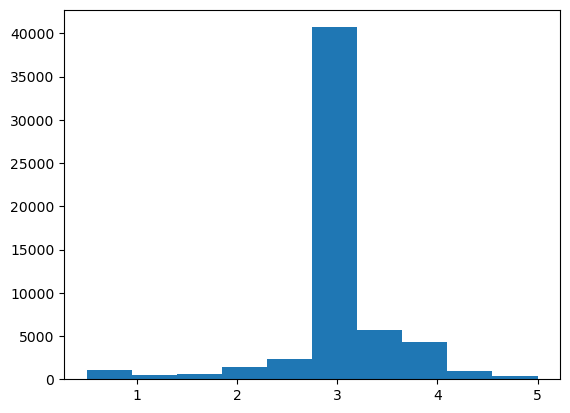

In [27]:
movies_df.rating_mean.hist(bins=10)
plt.grid(False)
plt.show()

Распределение жанров фильмов

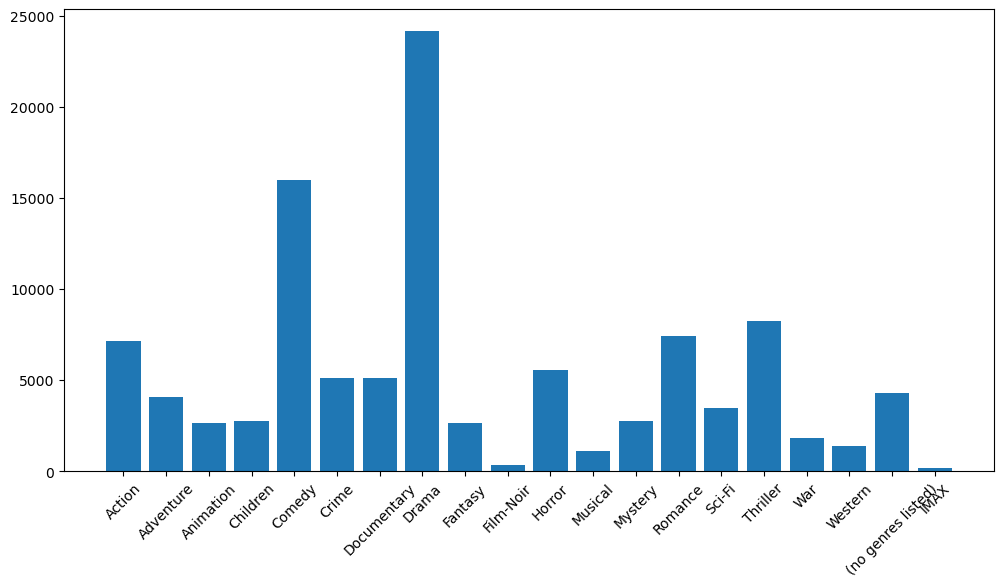

In [47]:
plt.figure(figsize=(12,6))
plt.bar(movies_df[genres_list].sum().index, movies_df[genres_list].sum().values)
plt.xticks(rotation = 45)
plt.show()

## Модель с классическими эмбедингами

In [20]:
import tensorflow as tf
from tensorflow import keras
from keras import Input, Model, layers, Sequential
from tensorflow.keras.optimizers.legacy import Adam

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

Создание эмбедингов для названий фильмов

In [22]:
movie_title_lookup = layers.StringLookup()
movie_title_lookup.adapt(movies_df["title"])

In [23]:
num_hashing_bins = 200_000

movie_title_hashing = layers.Hashing(num_bins=num_hashing_bins)

Подготовка датасета

In [24]:
ratings_df = ratings_df.drop('timestamp', axis=1)
ratings_df = pd.merge(ratings_df, movies_df, how='left', left_on='movieId', right_on='movieId')
ratings_df['title'] = movie_title_lookup(ratings_df["title"]).numpy()
ratings_df.head()

,userId,movieId,rating,title,year,Action,Adventure,Animation,Children,Comedy,...,Romance,Sci-Fi,Thriller,War,Western,(no genres listed),IMAX,rating_mean,rating_std,rating_count
0,1,307,3.5,7878,1993,0,0,0,0,0,...,0,0,0,0,0,0,0,4.036164,0.959485,318.0
1,1,481,3.5,31901,1993,0,0,0,0,0,...,0,0,1,0,0,0,0,3.371542,0.886573,253.0
2,1,1091,1.5,4643,1989,0,0,0,0,1,...,0,0,0,0,0,0,0,2.815421,1.122663,214.0
3,1,1257,4.5,49324,1985,0,0,0,0,1,...,1,0,0,0,0,0,0,3.799550,0.921905,222.0
4,1,1449,4.5,5104,1996,0,0,0,0,1,...,0,0,0,0,0,0,0,3.916667,0.974243,246.0


In [25]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 28 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   userId              1000000 non-null  int64  
 1   movieId             1000000 non-null  int64  
 2   rating              1000000 non-null  float64
 3   title               1000000 non-null  int64  
 4   year                1000000 non-null  int32  
 5   Action              1000000 non-null  int32  
 6   Adventure           1000000 non-null  int32  
 7   Animation           1000000 non-null  int32  
 8   Children            1000000 non-null  int32  
 9   Comedy              1000000 non-null  int32  
 10  Crime               1000000 non-null  int32  
 11  Documentary         1000000 non-null  int32  
 12  Drama               1000000 non-null  int32  
 13  Fantasy             1000000 non-null  int32  
 14  Film-Noir           1000000 non-null  int32  
 15  Horror          

In [26]:
X = ratings_df.drop('rating', axis=1)
X

,userId,movieId,title,year,Action,Adventure,Animation,Children,Comedy,Crime,...,Romance,Sci-Fi,Thriller,War,Western,(no genres listed),IMAX,rating_mean,rating_std,rating_count
0,1,307,7878,1993,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4.036164,0.959485,318.0
1,1,481,31901,1993,0,0,0,0,0,0,...,0,0,1,0,0,0,0,3.371542,0.886573,253.0
2,1,1091,4643,1989,0,0,0,0,1,0,...,0,0,0,0,0,0,0,2.815421,1.122663,214.0
3,1,1257,49324,1985,0,0,0,0,1,0,...,1,0,0,0,0,0,0,3.799550,0.921905,222.0
4,1,1449,5104,1996,0,0,0,0,1,0,...,0,0,0,0,0,0,0,3.916667,0.974243,246.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,10073,1370,42615,1990,1,1,0,0,0,0,...,0,0,1,0,0,0,0,3.421875,0.858592,672.0
999996,10073,1377,49959,1992,1,0,0,0,0,1,...,0,0,0,0,0,0,0,3.131879,0.923484,527.0
999997,10073,1407,1176,1996,0,0,0,0,1,0,...,0,0,1,0,0,0,0,3.191926,1.131900,706.0
999998,10073,1466,42053,1997,0,0,0,0,0,1,...,0,0,0,0,0,0,0,3.806977,0.770189,430.0


In [27]:
y = ratings_df['rating']
y

0         3.5
1         3.5
2         1.5
3         4.5
4         4.5
         ... 
999995    3.5
999996    3.5
999997    3.0
999998    4.0
999999    3.0
Name: rating, Length: 1000000, dtype: float64

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, shuffle=True)

In [29]:
num_users = ratings_df.userId.nunique()
num_movies = movies_df.shape[0]
num_features = movies_df.shape[1]
rows_count = ratings_df.shape[0]
emb_size = 32
n_features = 5
n_genres = len(genres_list)

In [34]:
movie_title_input = keras.Input(shape=(1,), name='movie_title')
movie_title_emb = layers.Embedding(output_dim=emb_size, input_dim=num_movies+1, input_length=rows_count+1, name='movie_title_emb')(movie_title_input)
movie_title_vec = layers.Flatten(name='flatten_movie_title')(movie_title_emb)

movie_features_input = keras.Input(shape=(n_genres+n_features,), name='movie_features')

movie_vec_concat = layers.Concatenate(name='movie_vec', axis=1)([movie_title_vec, movie_features_input])

movie_model = keras.Model(inputs=[movie_title_input, movie_features_input], outputs=movie_vec_concat)

user_input = keras.Input(shape=(1,), name='user_id')
user_emb = layers.Embedding(output_dim=emb_size + n_genres + n_features, input_dim=num_users+1, input_length=rows_count+1, name='user_emb')(user_input)
user_vec = layers.Flatten(name='FlattenUser')(user_emb)

user_model = keras.Model(inputs=user_input, outputs=user_vec)

merged = layers.Dot(name = 'dot_product', normalize = True, axes=1)([movie_vec_concat, user_vec])
merged_dropout = layers.Dropout(0.2)(merged)


dense_1 = layers.Dense(256,name='FullyConnected-1')(merged)
dropout_1 = layers.Dropout(0.2,name='Dropout_1')(dense_1)

dense_2 = layers.Dense(128,name='FullyConnected-2')(dropout_1)
dropout_2 = layers.Dropout(0.2,name='Dropout_2')(dense_2)

dense_3 = keras.layers.Dense(32,name='FullyConnected-3')(dropout_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout_3')(dense_3)

dense_4 = keras.layers.Dense(8,name='FullyConnected-4', activation='relu')(dropout_3)

result = layers.Dense(1, name='result', activation="relu")(dense_4)

adam = keras.optimizers.Adam(learning_rate=0.001)
model = keras.Model([movie_title_input, movie_features_input, user_input], result)
model.compile(optimizer=adam, loss= 'mean_absolute_error', metrics='mean_squared_error')


In [35]:
keras.utils.plot_model(model, show_shapes=True) 

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [36]:
callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10),
             keras.callbacks.ModelCheckpoint('besttest.h5', save_best_only=True)]

history = model.fit([X_train.title, X_train.drop(['title', 'userId'], axis=1), X_train['userId']], y_train, batch_size=100,
                              epochs=50, validation_data=([X_valid.title, X_valid.drop(['title', 'userId'], axis=1), X_valid['userId']], y_valid),
                              verbose=1, 
                              callbacks = callbacks)

Epoch 1/50
9000/9000 [==============================] - 351s 39ms/step - loss: 0.7888 - mean_squared_error: 1.0688 - val_loss: 0.7682 - val_mean_squared_error: 0.9645
Epoch 2/50
9000/9000 [==============================] - 348s 39ms/step - loss: 0.7347 - mean_squared_error: 0.9599 - val_loss: 0.7501 - val_mean_squared_error: 0.9435
Epoch 3/50
9000/9000 [==============================] - 363s 40ms/step - loss: 0.7255 - mean_squared_error: 0.9462 - val_loss: 0.7353 - val_mean_squared_error: 0.9321
Epoch 4/50
9000/9000 [==============================] - 335s 37ms/step - loss: 0.7186 - mean_squared_error: 0.9365 - val_loss: 0.7268 - val_mean_squared_error: 0.9462
Epoch 5/50
9000/9000 [==============================] - 337s 37ms/step - loss: 0.7142 - mean_squared_error: 0.9299 - val_loss: 0.7363 - val_mean_squared_error: 0.9268
Epoch 6/50
9000/9000 [==============================] - 337s 37ms/step - loss: 0.7110 - mean_squared_error: 0.9255 - val_loss: 0.7267 - val_mean_squared_error: 0.927

Epoch 50/50
9000/9000 [==============================] - 349s 39ms/step - loss: 0.6641 - mean_squared_error: 0.8533 - val_loss: 0.6902 - val_mean_squared_error: 0.8934


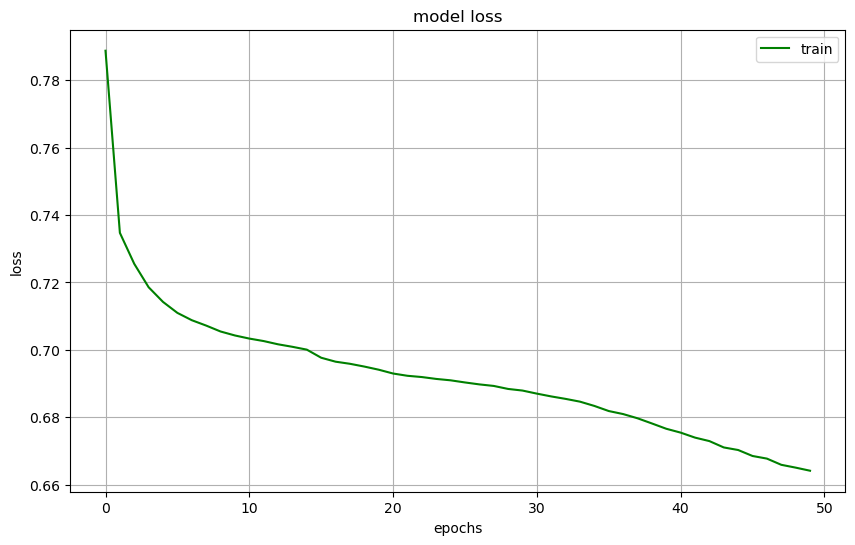

In [37]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'] , 'g')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train'], loc='upper right')
plt.grid(True)
plt.show()

In [39]:
model.save('model/simple_emb/')

INFO:tensorflow:Assets written to: model/simple_emb/assets


INFO:tensorflow:Assets written to: model/simple_emb/assets


In [ ]:
X_train.shape